# Results analysis for RB optimization on qubit D1

The notebook contains the results analysis for the optimization of RB fidelity on qubit D1.

The optimization was run without a previous recalibration of the qubit, this may have influenced the results. 

Optimization was run using Nelder-Mead with a fixed number of maximum iteration (no constrain on maximum number function evaluation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns

In [2]:
target = 'D1'
method = "init_simplex"

root_directory = f"../../optimization_data/D1_init_simplex_20241110_211211/"
unzip_directory = f"../../opt_test_unzipped/D1_init_simplex_20241110_211211/"
print(root_directory)
print(unzip_directory)
# unzip_data_npz(root_directory, unzip_directory)

../../optimization_data/D1_init_simplex_20241110_211211/
../../opt_test_unzipped/D1_init_simplex_20241110_211211/


## Results analysis from qibocal output folders

In [3]:
path = os.path.join('../', root_directory, 'data/')
print(path)

rb_paths = [item for item in os.listdir(path) if item.startswith('rb_ondevice') 
            and os.path.isdir(os.path.join(path, item))]
sorted_rb_items = sorted(rb_paths, key=lambda x: int(x.split('-')[1]))
print(len(sorted_rb_items))

../../../optimization_data/D1_init_simplex_20241110_211211/data/
145


In [4]:
all_decay_params, all_decay_errs = [], []
for rbpath in sorted_rb_items:
    with open(f"{path}{rbpath}/results.json") as f:
        data_dict = json.load(f)
    popt = data_dict['"pars"']['"D1"']
    pcov = np.array(data_dict['"cov"']['"D1"']).reshape(3, 3)
    perr = np.sqrt(np.diag(pcov))
    all_decay_params.append(popt[2])
    all_decay_errs.append(perr[2])

all_decay_params, all_decay_errs = np.array(all_decay_params), np.array(all_decay_errs)
# print(all_decay_params, all_decay_errs)

infidelity = (1 - all_decay_params) / 2
pulse_fidelities = 1 - infidelity / 1.875

pulse_fidelities_err = all_decay_errs / (1.875 * 2)

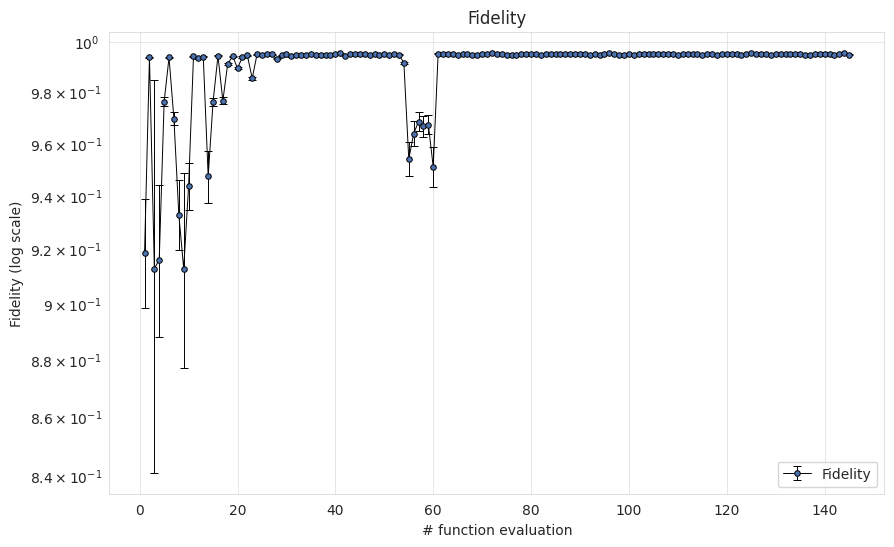

In [5]:
pulse_fidelities_err_clipped = np.where(
    np.array(pulse_fidelities_err) > 2, np.nan, pulse_fidelities_err
)


sns.set_style("whitegrid")  # or "ticks" for bordered but clean style
color = sns.color_palette("deep")[0]  # blue

plt.rcParams.update(
    {
        "axes.edgecolor": "lightgrey",
        "axes.linewidth": 0.5,
        "grid.color": "lightgrey",
        "grid.linewidth": 0.4,
    }
)
x = np.arange(1, len(pulse_fidelities) + 1)

plt.figure(figsize=(10, 6))
plt.errorbar(
    x,
    pulse_fidelities,
    yerr=pulse_fidelities_err_clipped,
    fmt="o",
    linestyle="-",
    markersize=4,
    color="black",
    markerfacecolor=color,
    ecolor="black",
    markeredgewidth=0.7,
    linewidth=0.7,
    alpha=1,
    capsize=3,
)
plt.xlabel("# function evaluation")
plt.ylabel("Fidelity (log scale)")
plt.yscale("log")
plt.title(f"Fidelity")
plt.legend(["Fidelity"], loc="best")
plt.grid(True)

ax = plt.gca()
ax.spines["top"].set_color("lightgrey")
ax.spines["right"].set_color("lightgrey")
ax.spines["bottom"].set_color("lightgrey")
ax.spines["left"].set_color("lightgrey")
ax.spines["top"].set_linewidth(0.5)
ax.spines["right"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)

plt.show()

## Results analysis from optimization history

In this section the data analysis was carried out using data and information stored in the the output of the optimization routine.

This way we are ablo to retrive also the values of the optimized paramters for the optimization history.

Unfortunately no error was estimated runtime during optimization so no information is available for error.

In [6]:
loaded = np.load('optimization_history.npz')
iterations = loaded['iterations']
parameters = loaded['parameters']
objective_values = loaded['objective_values']
objective_values_error = loaded['objective_value_errors']

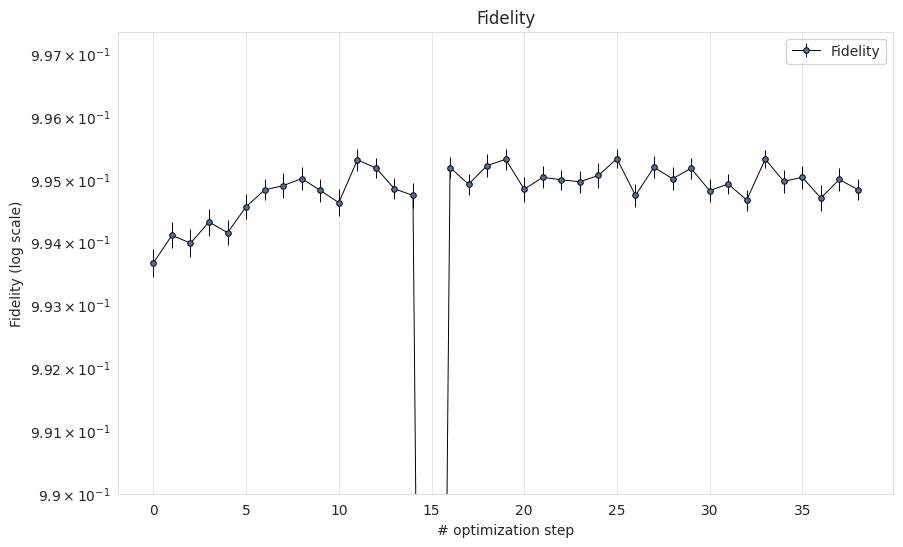

In [7]:
sns.set_style("whitegrid")  # or "ticks" for bordered but clean style
color = sns.color_palette("deep")[0]  # blue

plt.rcParams.update(
    {
        "axes.edgecolor": "lightgrey",
        "axes.linewidth": 0.5,
        "grid.color": "lightgrey",
        "grid.linewidth": 0.4,
    }
)

plt.figure(figsize=(10, 6)) 
plt.errorbar(iterations, 1-objective_values, yerr=objective_values_error, fmt = 'o', markersize=4, color='black', linestyle='-',
         markerfacecolor=color, markeredgewidth=0.7, linewidth=0.7, alpha=1)
plt.xlabel('# optimization step')
plt.ylabel('Fidelity (log scale)')
plt.yscale('log')
plt.ylim(bottom=9.9e-1)
plt.title(f'Fidelity')
plt.legend(['Fidelity'], loc='best')
plt.grid(True)

ax = plt.gca()
ax.spines["top"].set_color("lightgrey")
ax.spines["right"].set_color("lightgrey")
ax.spines["bottom"].set_color("lightgrey")
ax.spines["left"].set_color("lightgrey")
ax.spines["top"].set_linewidth(0.5)
ax.spines["right"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)

plt.show()

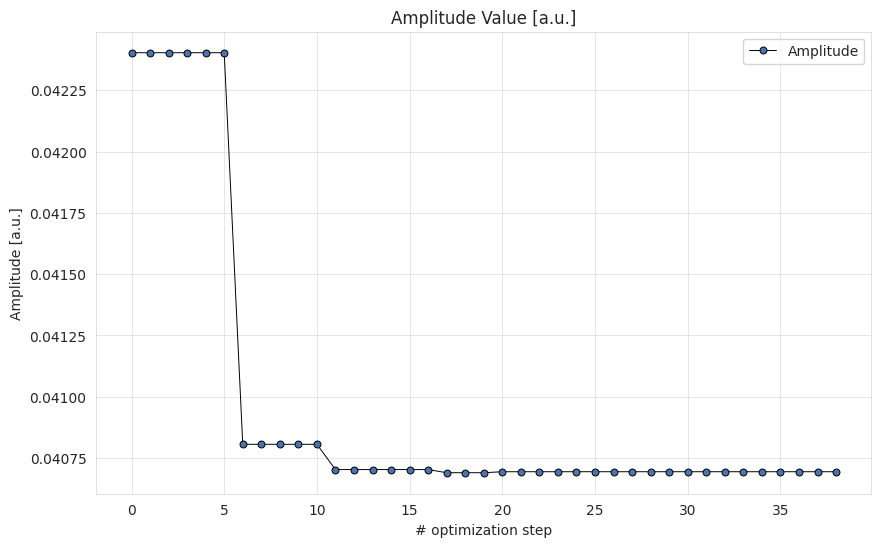

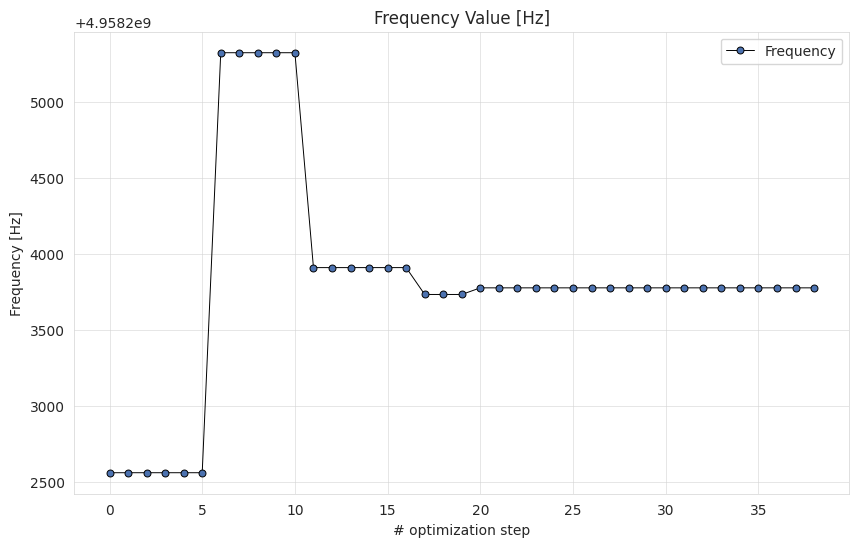

In [8]:
params_name = ["Amplitude", "Frequency", r'$\beta$']
unit_measure = ["[a.u.]", "[Hz]", ""]

sns.set_style("whitegrid") 
plt.rcParams.update(
    {
        "axes.edgecolor": "lightgrey",
        "axes.linewidth": 0.5,
        "grid.color": "lightgrey",
        "grid.linewidth": 0.4,
    }
)

for i in range(parameters.shape[1]):
    plt.figure(figsize=(10, 6))  
    plt.plot(
        iterations,
        parameters[:, i],
        "o-",
        markersize=5,
        color="black",
        markerfacecolor=color,
        markeredgewidth=0.7,
        linewidth=0.7,
        alpha=1,
        label=f"{params_name[i]}",
    )
    plt.xlabel("# optimization step")
    plt.ylabel(f"{params_name[i]} {unit_measure[i]}")
    plt.title(f"{params_name[i]} Value {unit_measure[i]}")
    plt.legend([f"{params_name[i]}"],loc='best')

    # Make grid and spines subtle
    plt.grid(True)
    ax = plt.gca()
    ax.spines["top"].set_color("lightgrey")
    ax.spines["right"].set_color("lightgrey")
    ax.spines["bottom"].set_color("lightgrey")
    ax.spines["left"].set_color("lightgrey")

    ax.spines["top"].set_linewidth(0.5)
    ax.spines["right"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)

    plt.show()

# Multidimensional plot

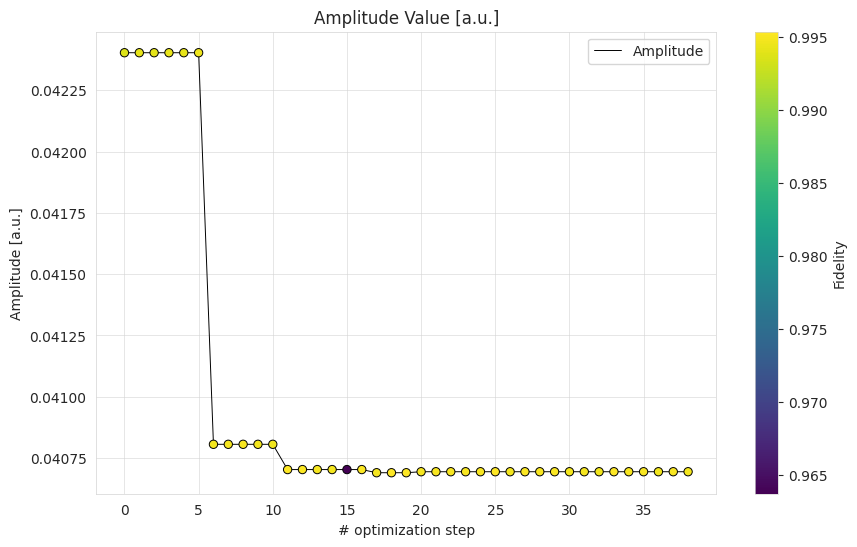

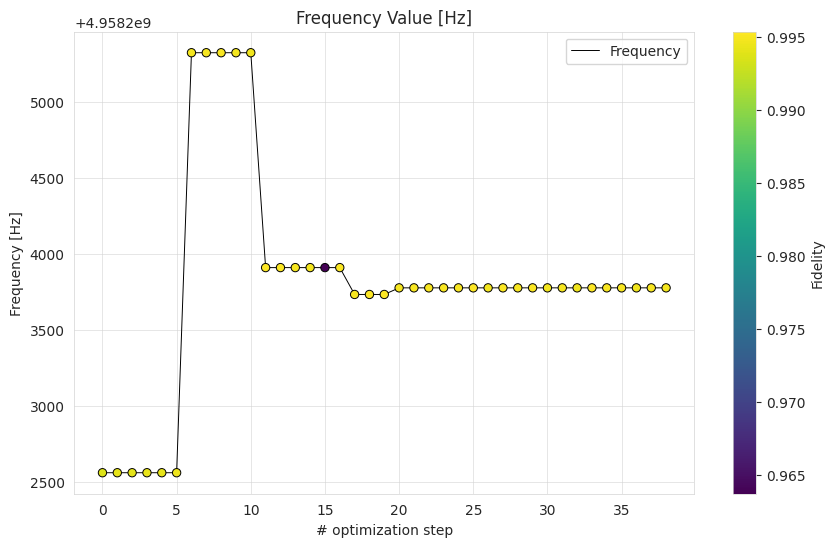

In [9]:
for i in range(parameters.shape[1]):
    plt.figure(figsize=(10, 6))  

    plt.plot(
        iterations,
        parameters[:, i],
        color="black",
        markerfacecolor=color,
        markeredgewidth=0.7,
        linewidth=0.7,
        alpha=1,
        label=f"{params_name[i]}",
    )
    # Add scatter plot for the actual data points, using colors to represent the scaling of another parameter
    sc = plt.scatter(iterations, parameters[:, i], c=1-objective_values, cmap='viridis', edgecolor='k', linewidths=0.7, zorder=2)

    plt.xlabel("# optimization step")
    plt.ylabel(f"{params_name[i]} {unit_measure[i]}")
    plt.title(f"{params_name[i]} Value {unit_measure[i]}")
    plt.legend([f"{params_name[i]}"], loc="best")

    # Add a color bar to show the scaling of another parameter
    cbar = plt.colorbar(sc)
    cbar.set_label('Fidelity') 

    plt.grid(True)
    ax = plt.gca()
    ax.spines["top"].set_color("lightgrey")
    ax.spines["right"].set_color("lightgrey")
    ax.spines["bottom"].set_color("lightgrey")
    ax.spines["left"].set_color("lightgrey")
    ax.spines["top"].set_linewidth(0.5)
    ax.spines["right"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.spines["left"].set_linewidth(0.5)

    plt.show()

## Result object analysis

In this section I print and explore the results of the optimization cycle as standard output of the `scipy.minimize` method

In [10]:
import pickle

with open('optimization_result.pkl', 'rb') as file:
    result = pickle.load(file)

print(result)

{'optimization_result':        message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.004593029980242255
             x: [ 4.069e-02  4.958e+09]
           nit: 40
          nfev: 106
 final_simplex: (array([[ 4.069e-02,  4.958e+09],
                       [ 4.069e-02,  4.958e+09],
                       [ 4.069e-02,  4.958e+09]]), array([ 4.593e-03,  4.774e-03,  4.781e-03])), 'elapsed_time': 3198.8486890792847}
